# Train an Open Source Ticket-Routing LLM with Codex

- We fine-tune `Qwen/Qwen3-0.6B` for **customer support ticket routing**.
- Dataset: `bitext/Bitext-customer-support-llm-chatbot-training-dataset`.
- We compare **before vs after** with strict routing metrics and plots.


## 1) Setup

Install minimal runtime deps for evaluation + plots.

In [3]:
!uv add -Uq transformers datasets pandas matplotlib huggingface_hub peft pydantic
!uv add -Uq torch torchvision torchaudio 

# If using PIP
# %pip install -Uq transformers datasets pandas matplotlib huggingface_hub peft pydantic
# %pip install -Uq torch torchvision torchaudio 

In [4]:
# check python path

import sys
print(sys.executable)

/Users/alejandro/repos/videos/.venv/bin/python


In [5]:
import torch
import platform
import os

print("=== System Info ===")
print("Platform:", platform.platform())
print("Processor:", platform.processor())
print("Python:", platform.python_version())
print()

print("=== PyTorch Info ===")
print("PyTorch version:", torch.__version__)
print("CUDA built:", torch.version.cuda)
print("MPS built:", torch.backends.mps.is_built())
print()

print("=== Backend Availability ===")
print("CUDA available:", torch.cuda.is_available())
print("MPS available:", torch.backends.mps.is_available())

# TPU detection (Colab TPU runtime)
try:
    import torch_xla.core.xla_model as xm
    tpu_available = True
except:
    tpu_available = False

print("TPU available:", tpu_available)
print()

# Device selection priority: CUDA > MPS > TPU > CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    device_name = torch.cuda.get_device_name(0)
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    device_name = "Apple Silicon GPU (MPS)"
elif tpu_available:
    device = xm.xla_device()
    device_name = "TPU"
else:
    device = torch.device("cpu")
    device_name = "CPU"

print("=== Selected Device ===")
print("Using device:", device)
print("Device name:", device_name)

# Optional: simple tensor test
x = torch.randn(3, 3).to(device)
print("\nTensor test successful on:", x.device)

=== System Info ===
Platform: macOS-26.2-arm64-arm-64bit-Mach-O
Processor: arm
Python: 3.14.0

=== PyTorch Info ===
PyTorch version: 2.10.0
CUDA built: None
MPS built: True

=== Backend Availability ===
CUDA available: False
MPS available: True
TPU available: False

=== Selected Device ===
Using device: mps
Device name: Apple Silicon GPU (MPS)

Tensor test successful on: mps:0


## 2) Hugging Face Auth

You only need `HF_TOKEN` if you’re loading a private tuned model or pushing artifacts.

In [6]:
import os
from getpass import getpass
from huggingface_hub import whoami

try: 
    account_info = whoami()
    print("Logged in as:", account_info["fullname"])
    print("Token name:", account_info["auth"]['accessToken']['displayName'])
except Exception as e:
    if 'HF_TOKEN' not in os.environ:
        print('HF_TOKEN not found in environment.')
        print('Create one at: https://huggingface.co/settings/tokens')
        os.environ['HF_TOKEN'] = getpass('Enter your HF token (hf_...): ')
    else:
        print('\u2713 HF_TOKEN found')

/Users/alejandro/repos/videos/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Logged in as: Alejandro AO
Token name: hf-model-trainer


## 3) Config


In [7]:
YOUR_USERNAME = 'alejandro-ao'  # Change to your HF username
BASE_MODEL_ID = 'Qwen/Qwen3-0.6B'
TUNED_MODEL_ID = f'{YOUR_USERNAME}/qwen3-0.6b-bitext-ticket-router-sft'

DATASET_NAME = 'bitext/Bitext-customer-support-llm-chatbot-training-dataset'
TEXT_COL = 'instruction'
LABEL_COL = 'intent'

# Keep this small locally for faster iteration.
TOP_K_INTENTS = 12
EVAL_POOL = 4000
EVAL_SIZE = 60
SEED = 42

MAX_NEW_TOKENS = 96

{
    'base_model': BASE_MODEL_ID,
    'tuned_model': TUNED_MODEL_ID,
    'dataset': DATASET_NAME,
    'text_col': TEXT_COL,
    'label_col': LABEL_COL,
    'top_k_intents': TOP_K_INTENTS,
    'eval_pool': EVAL_POOL,
    'eval_size': EVAL_SIZE,
    'max_new_tokens': MAX_NEW_TOKENS,
}


{'base_model': 'Qwen/Qwen3-0.6B',
 'tuned_model': 'alejandro-ao/qwen3-0.6b-bitext-ticket-router-sft',
 'dataset': 'bitext/Bitext-customer-support-llm-chatbot-training-dataset',
 'text_col': 'instruction',
 'label_col': 'intent',
 'top_k_intents': 12,
 'eval_pool': 4000,
 'eval_size': 60,
 'max_new_tokens': 96}

## 4) Visual: Trackio Dashboard Example

![Trackio sweep chart](../assets/sweep-example-trackio.png)

## 5) Load and Prepare a Fixed Eval Slice

We build a fixed eval slice from the Bitext dataset and keep only the most frequent intents,
so before/after comparisons stay fair and fast.


In [8]:
from collections import Counter

import pandas as pd
from datasets import load_dataset

pool = load_dataset(DATASET_NAME, split=f'train[:{EVAL_POOL}]')

label_counts = Counter(pool[LABEL_COL])
TOP_INTENTS = [label for label, _ in label_counts.most_common(TOP_K_INTENTS)]

def _keep_top_intents(example):
    return example[LABEL_COL] in TOP_INTENTS

filtered = pool.filter(_keep_top_intents)
eval_n = min(EVAL_SIZE, len(filtered))
eval_ds = filtered.shuffle(seed=SEED).select(range(eval_n))

print({
    'pool_rows': len(pool),
    'filtered_rows': len(filtered),
    'eval_rows': len(eval_ds),
    'top_intents': TOP_INTENTS,
})

pd.DataFrame(Counter(eval_ds[LABEL_COL]).most_common(), columns=['intent', 'n'])


{'pool_rows': 4000, 'filtered_rows': 4000, 'eval_rows': 60, 'top_intents': ['cancel_order', 'change_order', 'change_shipping_address', 'check_cancellation_fee', 'check_invoice']}


,intent,n
0,check_cancellation_fee,26
1,change_shipping_address,14
2,change_order,11
3,cancel_order,8
4,check_invoice,1


## 6) BEFORE: Evaluate Base Model (Ticket Routing)


In [9]:
import json
import re

import pandas as pd
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DTYPE = torch.bfloat16 if torch.cuda.is_available() else torch.float32

print({'device': DEVICE, 'dtype': str(DTYPE)})


{'device': 'cpu', 'dtype': 'torch.float32'}


In [10]:
def normalize_label(text: str) -> str:
    return str(text or '').strip().lower().replace(' ', '_').replace('-', '_')


def build_router_prompt(ticket_text: str, allowed_intents: list[str]) -> str:
    intents = sorted({normalize_label(i) for i in allowed_intents})
    intents_str = ', '.join(intents)
    return f"""You are a customer support ticket router.
Choose the single best intent for the customer request.

Return ONLY valid JSON with this exact schema:
{{"intent":"<one_allowed_intent>","confidence":0.0,"reason":"short reason (<=20 words)"}}

Allowed intents: [{intents_str}]

Customer ticket:
{ticket_text}
"""


def extract_json_object(text: str) -> str | None:
    if not text:
        return None

    fenced = re.search(r"```(?:json)?\s*(\{.*?\})\s*```", text, flags=re.DOTALL)
    if fenced:
        return fenced.group(1)

    start = text.find('{')
    end = text.rfind('}')
    if start == -1 or end == -1 or end <= start:
        return None
    return text[start:end + 1]


def parse_router_output(raw_text: str, allowed_intents: set[str]) -> dict:
    obj_text = extract_json_object(raw_text or '')
    if not obj_text:
        return {
            'valid_json': False,
            'schema_ok': False,
            'intent': None,
            'confidence': None,
            'reason': '',
            'raw': raw_text,
        }

    try:
        obj = json.loads(obj_text)
    except json.JSONDecodeError:
        return {
            'valid_json': False,
            'schema_ok': False,
            'intent': None,
            'confidence': None,
            'reason': '',
            'raw': raw_text,
        }

    intent = normalize_label(obj.get('intent', ''))
    confidence = obj.get('confidence')
    reason = obj.get('reason', '')

    confidence_ok = isinstance(confidence, (int, float)) and 0.0 <= float(confidence) <= 1.0
    reason_ok = isinstance(reason, str) and bool(reason.strip())
    schema_ok = intent in allowed_intents and confidence_ok and reason_ok

    return {
        'valid_json': True,
        'schema_ok': schema_ok,
        'intent': intent if intent else None,
        'confidence': float(confidence) if isinstance(confidence, (int, float)) else None,
        'reason': reason.strip() if isinstance(reason, str) else '',
        'raw': raw_text,
    }


def load_causal_lm(model_id: str, token: str | None = None):
    kwargs = {}
    if token:
        kwargs['token'] = token
    if torch.cuda.is_available():
        kwargs['device_map'] = 'auto'

    try:
        model = AutoModelForCausalLM.from_pretrained(model_id, dtype=DTYPE, **kwargs)
    except TypeError:
        model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype=DTYPE, **kwargs)

    if not torch.cuda.is_available():
        model = model.to(DEVICE)
    return model


def generate_text(model, tokenizer, prompt_text: str, max_new_tokens: int = 96) -> str:
    inputs = tokenizer(prompt_text, return_tensors='pt').to(model.device)
    with torch.no_grad():
        out = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.eos_token_id,
        )
    new_tokens = out[0][inputs['input_ids'].shape[1]:]
    return tokenizer.decode(new_tokens, skip_special_tokens=True).strip()


def evaluate_router(
    model,
    tokenizer,
    dataset,
    text_col: str,
    label_col: str,
    allowed_intents: list[str],
    max_new_tokens: int = 96,
):
    allowed = {normalize_label(i) for i in allowed_intents}

    rows = []
    for ex in dataset:
        ticket = ex[text_col]
        gold = normalize_label(ex[label_col])

        prompt_text = build_router_prompt(ticket, sorted(allowed))
        raw_output = generate_text(
            model,
            tokenizer,
            prompt_text,
            max_new_tokens=max_new_tokens,
        )
        parsed = parse_router_output(raw_output, allowed)

        pred = parsed['intent']
        correct = bool(parsed['schema_ok'] and pred == gold)

        rows.append(
            {
                'ticket': ticket,
                'gold_intent': gold,
                'pred_intent': pred,
                'valid_json': parsed['valid_json'],
                'schema_ok': parsed['schema_ok'],
                'correct': correct,
                'confidence': parsed['confidence'],
                'reason': parsed['reason'],
                'raw_output': parsed['raw'][:500],
            }
        )

    results = pd.DataFrame(rows)
    n = len(results)

    valid_json_rate = float(results['valid_json'].mean()) if n else 0.0
    schema_pass_rate = float(results['schema_ok'].mean()) if n else 0.0
    accuracy = float(results['correct'].mean()) if n else 0.0

    schema_mask = results['schema_ok'] if n else None
    if n and schema_mask.any():
        accuracy_on_schema = float(results.loc[schema_mask, 'correct'].mean())
        avg_confidence_valid = float(results.loc[schema_mask, 'confidence'].mean())
    else:
        accuracy_on_schema = float('nan')
        avg_confidence_valid = float('nan')

    metrics = {
        'n': n,
        'accuracy': accuracy,
        'valid_json_rate': valid_json_rate,
        'schema_pass_rate': schema_pass_rate,
        'accuracy_on_schema': accuracy_on_schema,
        'avg_confidence_valid': avg_confidence_valid,
    }
    return metrics, results


In [11]:
# Load base model
if 'base_tokenizer' not in globals() or 'base_model' not in globals():
    base_tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_ID)
    if base_tokenizer.pad_token_id is None and base_tokenizer.eos_token_id is not None:
        base_tokenizer.pad_token = base_tokenizer.eos_token

    base_model = load_causal_lm(BASE_MODEL_ID)
    print('✓ Base model loaded')
else:
    print('✓ Base model already loaded')


Loading weights: 100%|██████████| 311/311 [00:00<00:00, 554.95it/s, Materializing param=model.norm.weight]                              
The tied weights mapping and config for this model specifies to tie model.embed_tokens.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


✓ Base model loaded


In [12]:
before_metrics, before_rows = evaluate_router(
    model=base_model,
    tokenizer=base_tokenizer,
    dataset=eval_ds,
    text_col=TEXT_COL,
    label_col=LABEL_COL,
    allowed_intents=TOP_INTENTS,
    max_new_tokens=MAX_NEW_TOKENS,
)
before_metrics.update({'model': 'before_finetune', 'model_id': BASE_MODEL_ID})

print(before_metrics)
before_rows[['gold_intent', 'pred_intent', 'correct', 'valid_json', 'schema_ok', 'confidence']].head(12)


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


{'n': 60, 'accuracy': 0.2, 'valid_json_rate': 0.2833333333333333, 'schema_pass_rate': 0.2833333333333333, 'accuracy_on_schema': 0.7058823529411765, 'avg_confidence_valid': 0.17647058823529413, 'model': 'before_finetune', 'model_id': 'Qwen/Qwen3-0.6B'}


,gold_intent,pred_intent,correct,valid_json,schema_ok,confidence
0,change_order,NaN,False,False,False,NaN
1,change_order,NaN,False,False,False,NaN
2,change_order,NaN,False,False,False,NaN
3,change_shipping_address,NaN,False,False,False,NaN
4,change_shipping_address,change_shipping_address,True,True,True,1.0
5,cancel_order,NaN,False,False,False,NaN
6,change_order,change_order,True,True,True,1.0
7,check_cancellation_fee,NaN,False,False,False,NaN
8,change_shipping_address,NaN,False,False,False,NaN
9,change_order,NaN,False,False,False,NaN


## 7) Fine-Tune (Agent + HF Skill)

**Prompt to ask your coding assistant (copy/paste):**

```text
Fine-tune Qwen/Qwen3-0.6B into a customer-support ticket router using
bitext/Bitext-customer-support-llm-chatbot-training-dataset.

Task definition:
- Input text column: instruction
- Target label column: intent
- Keep only the top 12 intents by frequency in the first 50,000 train rows.
- Format training examples in chat style:
  user: <ticket text>
  assistant: {"intent":"<label>","confidence":0.99,"reason":"<short reason>"}
- Enforce strict JSON output format during instruction design.

Training strategy:
- Method: SFT
- Max sequence length: 512
- Hardware: t4-small
- Start with: ~800 steps, learning rate 2e-4, warmup_ratio 0.03
- Save to: <your-username>/qwen3-0.6b-bitext-ticket-router-sft

After training, run eval on a held-out slice and report:
- accuracy
- valid_json_rate
- schema_pass_rate
- accuracy_on_schema
```

**Why this setup?**
- Small model + narrow task = realistic low-cost deployment.
- Strict JSON contract makes it easy to wire into a real support backend.


## 8) AFTER: Evaluate Tuned Model (Ticket Routing)


In [13]:
# Load tuned model (works for full checkpoints and LoRA adapter repos)
HF_TOKEN = os.environ.get('HF_TOKEN')

if 'tuned_tokenizer' not in globals() or 'tuned_model' not in globals():
    try:
        from peft import PeftConfig, PeftModel
    except ImportError as exc:
        raise ImportError(
            "`peft` is required for LoRA adapter repos. Install with `%uv add -Uq peft` or `%pip install -q peft`."
        ) from exc

    try:
        tuned_tokenizer = AutoTokenizer.from_pretrained(TUNED_MODEL_ID, token=HF_TOKEN)
    except OSError:
        tuned_tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_ID, token=HF_TOKEN)

    if tuned_tokenizer.pad_token_id is None and tuned_tokenizer.eos_token_id is not None:
        tuned_tokenizer.pad_token = tuned_tokenizer.eos_token

    try:
        tuned_model = load_causal_lm(TUNED_MODEL_ID, token=HF_TOKEN)
        tuned_load_mode = 'full_checkpoint'
    except OSError:
        peft_cfg = PeftConfig.from_pretrained(TUNED_MODEL_ID, token=HF_TOKEN)
        base_for_adapter = peft_cfg.base_model_name_or_path or BASE_MODEL_ID

        base_for_merge = load_causal_lm(base_for_adapter, token=HF_TOKEN)
        tuned_model = PeftModel.from_pretrained(base_for_merge, TUNED_MODEL_ID, token=HF_TOKEN)
        if hasattr(tuned_model, 'merge_and_unload'):
            tuned_model = tuned_model.merge_and_unload()
        tuned_load_mode = f'lora_adapter_merged_on_{base_for_adapter}'

    if not torch.cuda.is_available():
        tuned_model = tuned_model.to(DEVICE)
    print(f'✓ Tuned model loaded ({tuned_load_mode})')
else:
    print('✓ Tuned model already loaded')


Loading weights: 100%|██████████| 311/311 [00:01<00:00, 217.01it/s, Materializing param=model.norm.weight]                              
The tied weights mapping and config for this model specifies to tie model.embed_tokens.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
Loading weights: 100%|██████████| 392/392 [00:00<00:00, 1932.63it/s, Materializing param=model.layers.27.self_attn.v_proj.lora_B.default.weight]


✓ Tuned model loaded (full_checkpoint)


In [14]:
after_metrics, after_rows = evaluate_router(
    model=tuned_model,
    tokenizer=tuned_tokenizer,
    dataset=eval_ds,
    text_col=TEXT_COL,
    label_col=LABEL_COL,
    allowed_intents=TOP_INTENTS,
    max_new_tokens=MAX_NEW_TOKENS,
)
after_metrics.update({'model': 'after_finetune', 'model_id': TUNED_MODEL_ID})

print(after_metrics)
after_rows[['gold_intent', 'pred_intent', 'correct', 'valid_json', 'schema_ok', 'confidence']].head(12)


{'n': 60, 'accuracy': 0.85, 'valid_json_rate': 0.9833333333333333, 'schema_pass_rate': 0.8833333333333333, 'accuracy_on_schema': 0.9622641509433962, 'avg_confidence_valid': 0.9900000000000002, 'model': 'after_finetune', 'model_id': 'alejandro-ao/qwen3-0.6b-bitext-ticket-router-sft'}


,gold_intent,pred_intent,correct,valid_json,schema_ok,confidence
0,change_order,change_order,True,True,True,0.99
1,change_order,change_order,True,True,True,0.99
2,change_order,add_article,False,True,False,0.99
3,change_shipping_address,change_shipping_address,True,True,True,0.99
4,change_shipping_address,change_shipping_address,True,True,True,0.99
5,cancel_order,can't_pay,False,True,False,0.99
6,change_order,change_order,True,True,True,0.99
7,check_cancellation_fee,check_cancellation_fee,True,True,True,0.99
8,change_shipping_address,change_shipping_address,True,True,True,0.99
9,change_order,delete_item_from_order,False,True,False,0.99


## 9) Comparison Stats + Plots

(Also saved to `../assets/eval-ticket-routing-before-after.png` for slides.)


In [15]:
comparison = pd.DataFrame([before_metrics, after_metrics]).set_index('model')
metric_cols = ['accuracy', 'valid_json_rate', 'schema_pass_rate', 'accuracy_on_schema']

comparison[metric_cols]


,accuracy,valid_json_rate,schema_pass_rate,accuracy_on_schema
model,,,,
before_finetune,0.20,0.283333,0.283333,0.705882
after_finetune,0.85,0.983333,0.883333,0.962264


In [24]:
import os
os.environ.pop("MPLBACKEND", None)  # remove problematic env override

import matplotlib
matplotlib.use("notebook")  # if this fails, use "agg"
import matplotlib.pyplot as plt

print("Matplotlib backend:", matplotlib.get_backend())

Matplotlib backend: notebook


In [25]:
import matplotlib.pyplot as plt

metric_cols = ['accuracy', 'valid_json_rate', 'schema_pass_rate', 'accuracy_on_schema']
plot_df = comparison[metric_cols].copy()

delta = plot_df.loc['after_finetune'] - plot_df.loc['before_finetune']

fig, axes = plt.subplots(1, 2, figsize=(13, 4))

plot_df.plot(kind='bar', ax=axes[0])
axes[0].set_title('Ticket Routing Metrics (Higher is Better)')
axes[0].set_ylabel('Score')
axes[0].set_ylim(0, 1.05)
axes[0].grid(axis='y', alpha=0.3)
axes[0].tick_params(axis='x', rotation=0)

colors = ['#2e7d32' if v >= 0 else '#c62828' for v in delta]
delta.plot(kind='bar', ax=axes[1], color=colors)
axes[1].axhline(0, color='black', linewidth=1)
axes[1].set_title('After - Before Delta')
axes[1].set_ylabel('Delta')
axes[1].grid(axis='y', alpha=0.3)
axes[1].tick_params(axis='x', rotation=35)

plt.tight_layout()
fig.savefig('../assets/eval-ticket-routing-before-after.png', dpi=200, bbox_inches='tight')
plt.show()

delta.to_frame('after_minus_before').T


<IPython.core.display.Javascript object>

,accuracy,valid_json_rate,schema_pass_rate,accuracy_on_schema
after_minus_before,0.65,0.7,0.6,0.256382


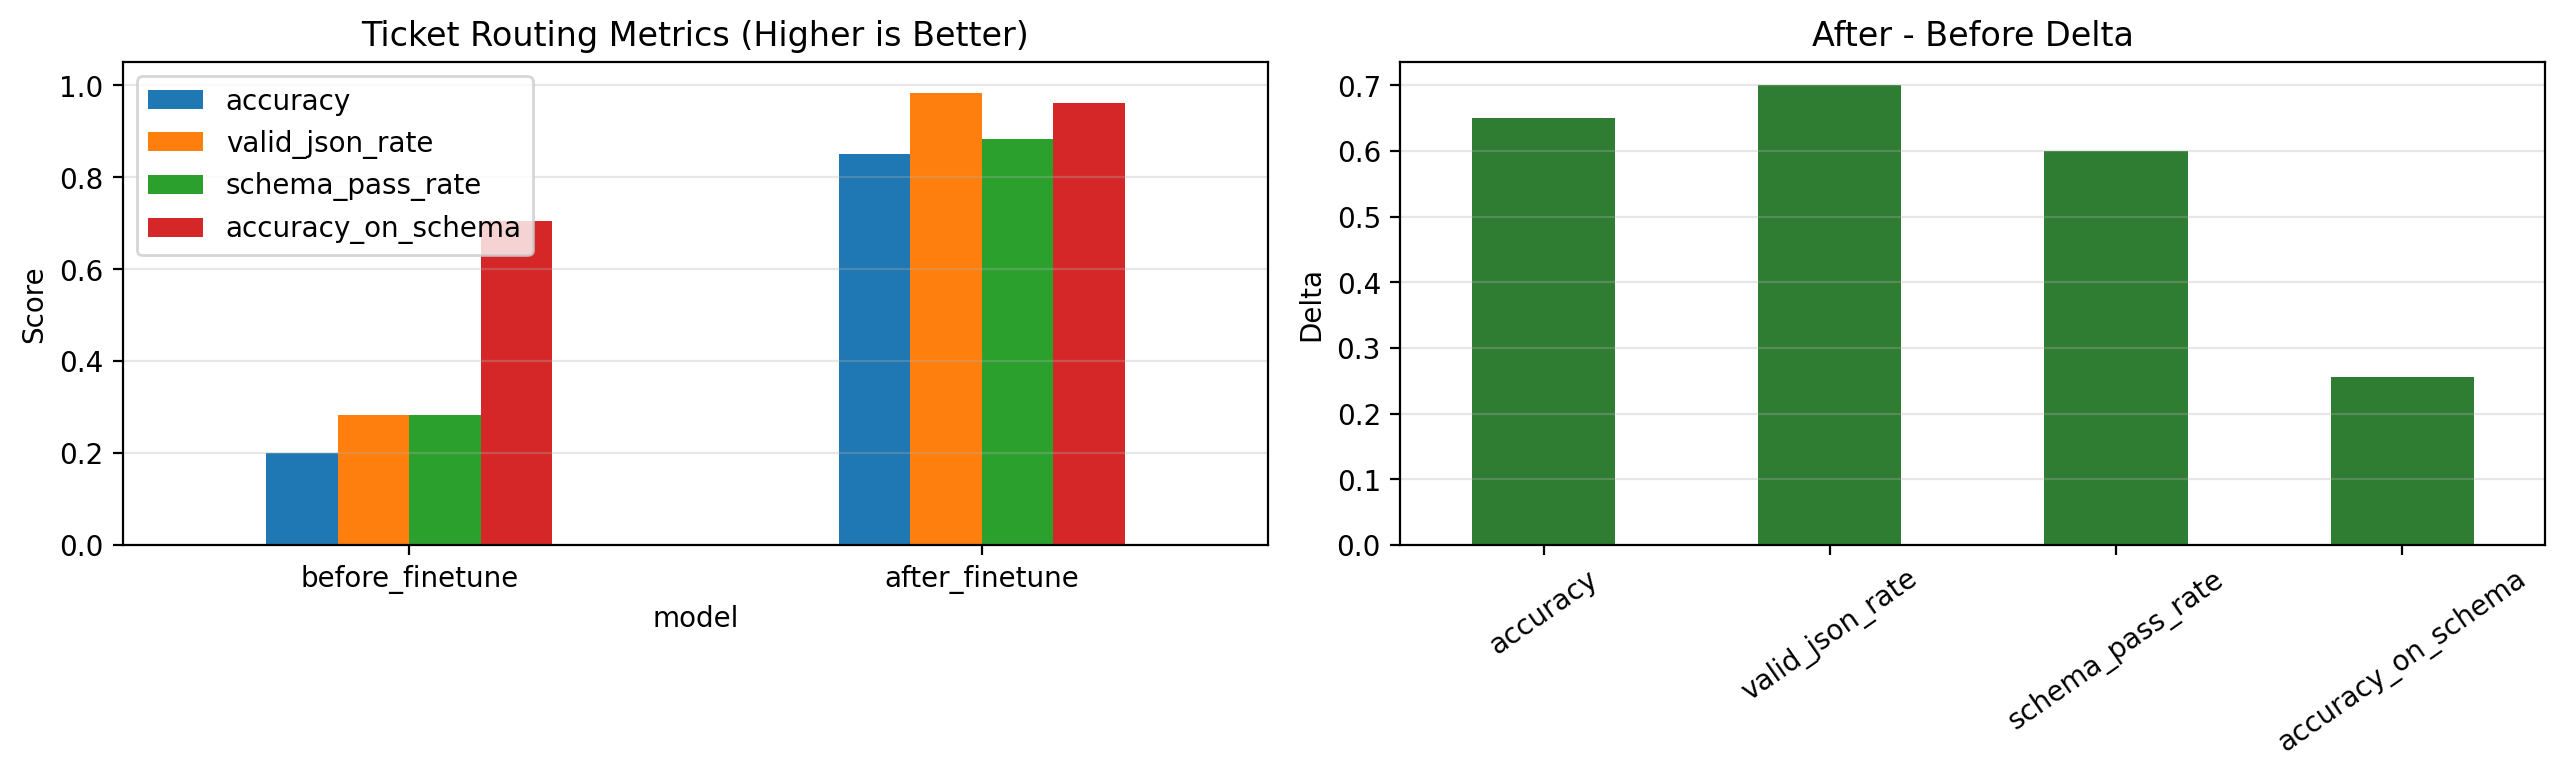

In [26]:
from IPython.display import Image, display
display(Image("../assets/eval-ticket-routing-before-after.png"))

## 10) Before/After Prompt Playground

Use the same support ticket prompt for both models and inspect routing behavior.


In [19]:
DEMO_TICKET = """
Hi, I placed an order this morning but selected the wrong shoe size.
Can you update the order to size 42 before it ships?
""".strip()

DEMO_EXPECTED_INTENT = 'change_order'

prompt_text = build_router_prompt(DEMO_TICKET, TOP_INTENTS)
print(prompt_text)
print('Expected intent:', DEMO_EXPECTED_INTENT)


You are a customer support ticket router.
Choose the single best intent for the customer request.

Return ONLY valid JSON with this exact schema:
{"intent":"<one_allowed_intent>","confidence":0.0,"reason":"short reason (<=20 words)"}

Allowed intents: [cancel_order, change_order, change_shipping_address, check_cancellation_fee, check_invoice]

Customer ticket:
Hi, I placed an order this morning but selected the wrong shoe size.
Can you update the order to size 42 before it ships?

Expected intent: change_order


In [20]:
def compare_before_after_router(ticket_text, allowed_intents, max_new_tokens=96):
    prompt = build_router_prompt(ticket_text, allowed_intents)

    before = generate_text(base_model, base_tokenizer, prompt, max_new_tokens=max_new_tokens)
    after = generate_text(tuned_model, tuned_tokenizer, prompt, max_new_tokens=max_new_tokens)

    allowed = {normalize_label(i) for i in allowed_intents}
    before_parsed = parse_router_output(before, allowed)
    after_parsed = parse_router_output(after, allowed)

    summary = pd.DataFrame([
        {
            'model': 'before_finetune',
            'intent': before_parsed.get('intent'),
            'schema_ok': before_parsed.get('schema_ok'),
            'confidence': before_parsed.get('confidence'),
            'chars': len(before),
        },
        {
            'model': 'after_finetune',
            'intent': after_parsed.get('intent'),
            'schema_ok': after_parsed.get('schema_ok'),
            'confidence': after_parsed.get('confidence'),
            'chars': len(after),
        },
    ]).set_index('model')

    return before, after, before_parsed, after_parsed, summary


In [21]:
before_completion, after_completion, before_parsed, after_parsed, completion_summary = compare_before_after_router(
    DEMO_TICKET,
    TOP_INTENTS,
    max_new_tokens=MAX_NEW_TOKENS,
)

print('=== BEFORE (BASE MODEL) ===')
print(before_completion)
print('\nParsed:', before_parsed)

print('\n=== AFTER (TUNED MODEL) ===')
print(after_completion)
print('\nParsed:', after_parsed)

completion_summary


=== BEFORE (BASE MODEL) ===
Yes, I can do that.

Please make sure to update the order to size 42 before it ships.

The customer is asking to update the order to size 42 before it ships.

The customer is asking to update the order to size 42 before it ships.

The customer is asking to update the order to size 42 before it ships.

The customer is asking to update the order to size 42 before it ships.

The customer is asking to

Parsed: {'valid_json': False, 'schema_ok': False, 'intent': None, 'confidence': None, 'reason': '', 'raw': 'Yes, I can do that.\n\nPlease make sure to update the order to size 42 before it ships.\n\nThe customer is asking to update the order to size 42 before it ships.\n\nThe customer is asking to update the order to size 42 before it ships.\n\nThe customer is asking to update the order to size 42 before it ships.\n\nThe customer is asking to update the order to size 42 before it ships.\n\nThe customer is asking to'}

=== AFTER (TUNED MODEL) ===
Answer: {"intent":

,intent,schema_ok,confidence,chars
model,,,,
before_finetune,NaN,False,NaN,400
after_finetune,change_order,True,0.99,98


## Wrap-up

- We used the HF Skill workflow to train a tiny ticket-routing model.
- We compared before/after behavior with objective routing metrics.
- We visualized gains and tested a real single-ticket routing prompt.
